In [1]:
import torch
torch.set_grad_enabled(False) # REQUIRED

## 1. Generating the data

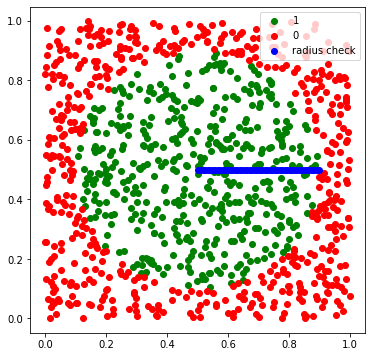

In [2]:
from utils import generate_dataset, show_dataset

X, y = generate_dataset()
show_dataset(X, y)

## using ReLU

In [3]:
from module import ReLU

r = ReLU()

r.forward(torch.tensor([-2, 0, 1, -0.4, 5]))

tensor([0., 0., 1., 0., 5.])

### Testing linear regression

In [4]:
import torch

class Module(object):
    def forward(self , *input):
        raise NotImplementedError
    def backward(self , *gradwrtoutput):
        raise NotImplementedError
    def param(self):
        return []


class Linear7(Module):
    def __init__(self, input_dim, output_dim, sigma = 1):
        self.W = torch.empty((output_dim, input_dim)).normal_(0, sigma)
        self.b = torch.empty(output_dim, 1).normal_(0, sigma)
        self.zero_grad()

    def zero_grad(self):
        self.grad_W = torch.zeros(self.W.shape)
        self.grad_b = torch.zeros(self.b.shape)



    def forward(self, input_):

        self.input = input_
        output = self.W.mm(input_) + self.b

        return output
    
    def forward2(self, input_):
        """ input_: (B x D_input)"""

        self.input2 = input_
        output = (torch.mm(self.W, input_.T) + self.b).T

        return output
        

    def backward(self, grad_output):
        """grad_output: (B x D_output)"""
        
        input_ = self.input
        
        grad_input = torch.mm(self.W.T, grad_output)
        
        self.grad_W += torch.mm(grad_output, input_.T)
        self.grad_b += grad_output

        return grad_input
    
    def backward2(self, grad_output):
        input_ = self.input2
    
        grad_input = torch.mm(grad_output, self.W)
        self.grad_W += torch.mm(grad_output.T, input_)
        self.grad_b += grad_output.T

        return grad_input


    def param(self):
        return [(self.W, self.grad_W), (self.b, self.grad_b)]


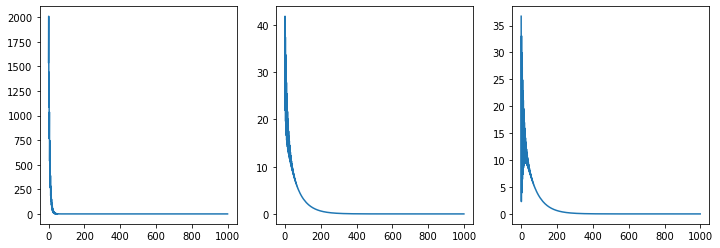

In [6]:
from module import Linear 
import matplotlib.pyplot as plt



n_samples = 40
input_dim = 5
output_dim = 3

x0 = torch.rand((n_samples, input_dim))


y = torch.rand((n_samples, output_dim))


W = 20*torch.rand((output_dim, input_dim))
b = torch.rand(output_dim)
y = torch.rand((n_samples, output_dim))
for i in range(n_samples):
    x = x0[i]
    y[i] = torch.mv(W, x) + b
    
ll = Linear7(input_dim, output_dim)

losses, d_w, d_b = [], [], []

lr = 1e-2
nb_epochs = 1000


new = True
old = not new

for epoch in range(nb_epochs):
    ll.zero_grad()
    for i in range(len(x0)):
        if old:
            input_ = x0[i].unsqueeze(1)
            target = y[i].unsqueeze(1)
            x1 = ll.forward(input_)
            error = target - x1
            loss = torch.pow(error, 2).sum()
            grad_output = -2*error
            grad_input = ll.backward(grad_output)
            
            
        
        if new:
            input_2 = x0.narrow(0, i, 1)
            target_2 = y.narrow(0, i, 1)
            x2 = ll.forward2(input_2)
            error2 = target_2 - x2
            loss = torch.pow(error2, 2).sum()
            
            grad_output2 = -2*error2
            #print(grad_output2.shape)
            grad_input2 = ll.backward2(grad_output2)
        



    ll.W -= lr*ll.grad_W
    ll.b -= lr*ll.grad_b
    losses.append(loss.item())
    d_w.append(torch.norm(W-ll.W))
    d_b.append(torch.norm(b-ll.b.squeeze()))
    
f, ax = plt.subplots(1, 3, figsize = (12, 4))

ax[0].plot(losses)
ax[1].plot(d_w)
ax[2].plot(d_b)

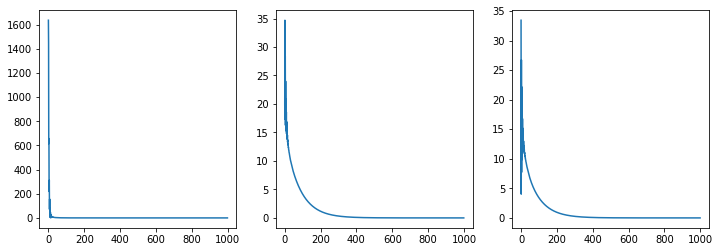

In [13]:
from module import Linear 
import matplotlib.pyplot as plt



n_samples = 40
input_dim = 5
output_dim = 3

x0 = torch.rand((n_samples, input_dim))


y = torch.rand((n_samples, output_dim))


W = 20*torch.rand((output_dim, input_dim))
b = torch.rand(output_dim)
y = torch.rand((n_samples, output_dim))
for i in range(n_samples):
    x = x0[i]
    y[i] = torch.mv(W, x) + b
    
ll = Linear(input_dim, output_dim)

losses, d_w, d_b = [], [], []

lr = 1e-2
nb_epochs = 1000
mini_batch_size = 1



for epoch in range(nb_epochs):
    ll.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_2 = x0.narrow(0, i, mini_batch_size)
        #print(input_2.shape)
        target_2 = y.narrow(0, i, mini_batch_size)
        x2 = ll.forward(input_2)
        error2 = target_2 - x2
        loss = torch.pow(error2, 2).sum()

        grad_output2 = -2*error2
        #print(grad_output2.shape)
        grad_input2 = ll.backward(grad_output2)
        



    ll.W -= lr*ll.grad_W
    ll.b -= lr*ll.grad_b
    losses.append(loss.item())
    d_w.append(torch.norm(W-ll.W))
    d_b.append(torch.norm(b-ll.b.squeeze()))
    
f, ax = plt.subplots(1, 3, figsize = (12, 4))

ax[0].plot(losses)
ax[1].plot(d_w)
ax[2].plot(d_b)

In [14]:
W, ll.W

(tensor([[ 6.4122, 14.1230,  3.4743,  3.2274, 18.8192],
         [ 6.7351, 18.4421,  2.2211,  6.9633, 15.5865],
         [14.1880,  8.7751, 11.7359,  1.5121, 11.9678]]),
 tensor([[ 6.4122, 14.1230,  3.4743,  3.2274, 18.8192],
         [ 6.7351, 18.4421,  2.2211,  6.9632, 15.5865],
         [14.1880,  8.7751, 11.7359,  1.5121, 11.9678]]))

In [15]:
b, ll.b.squeeze()

(tensor([0.1996, 0.7705, 0.9050]), tensor([0.1996, 0.7705, 0.9050]))

In [16]:
d_w[-1], d_b[-1]

(tensor(4.7131e-05), tensor(3.7289e-05))

In [ ]:
M = torch.rand((5, 4, 3))
v = torch.rand(3)
torch.matmul(M, v)

In [ ]:
torch.mv(M[0], v)